## This is notebook exploring camera calibration challenge 
 - If you want to use the baseline model provided in the repo, you need to install all the libraries. 
 - I work in conda and created a soccernet environment where I installed the necessary versions of torch, etc. 
 - The notebook mostly follows the baseline code provided in the official repo with some additional graphics the explain what's going on. 

In [2]:
# To download the data you can run this cell. 
# from SoccerNet.Downloader import SoccerNetDownloader
# mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="")
# mySoccerNetDownloader.downloadDataTask(task="calibration", split=["train","valid","test","challenge"])
# Unzip the data after download in the calibration folder

In [3]:
import copy
import json
import os.path
import random
from collections import deque
from pathlib import Path

import cv2 as cv
import numpy as np
import torch
import torch.backends.cudnn
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from torchvision.models.segmentation import deeplabv3_resnet50
from src.soccerpitch import SoccerPitch
from src.baseline_extremities import (generate_class_synthesis, join_points, get_line_extremities, get_support_center, synthesize_mask)
from src.baseline_extremities import SegmentationNetwork
#%matplotlib inline
from matplotlib import pyplot as plt

from datetime import datetime
import time
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

c:\Users\giuseppe.gagliardi\Documents\SoccerNet\calibration\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
start_time = datetime.now().strftime('%Y-%m-%d %H-%M-%S')
actual_time = time.time()
lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

In [5]:
# This is the image segmentation network provided in the repo. 
calib_net = SegmentationNetwork(
    "resources/soccer_pitch_segmentation.pth",
    "resources/mean.npy",
    "resources/std.npy")

In [6]:
dataset_dir = os.path.join('data', 'calibration')
dataset_dir = os.path.join(dataset_dir, 'valid')
frames = [f for f in os.listdir(dataset_dir) if ".jpg" in f]
output_prediction_folder = os.path.join('results', 'valid')
if not os.path.exists(output_prediction_folder):
    os.makedirs(output_prediction_folder)

In [7]:
# You can choose a different image from the data. I'll use frame_index throughout the whole notebook
frame_index_int = 1
frame = frames[frame_index_int]
prediction = dict()
count = 0
frame_path = os.path.join(dataset_dir, frame)
frame_index = frame.split(".")[0]
image = cv.imread(frame_path)
print(image.shape)

(540, 960, 3)


In [8]:
frame_paths = dict()
for f in frames:
    frame_paths.update({f.split(".")[0]: os.path.join(dataset_dir, f)})


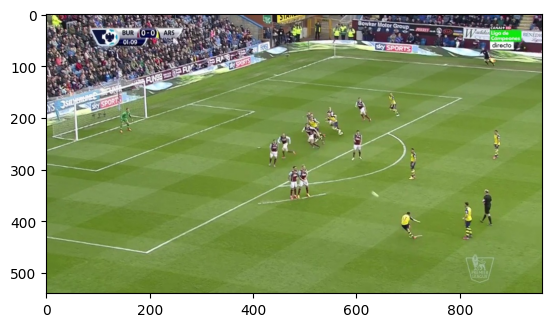

In [9]:
#Show the image with matplotlib
# This is the image for which we'll be trying to find field lines and camera calibration
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

In [10]:
# This command finds the segmented field lines. 
semlines = calib_net.analyse_image(image)
# The network returns an image dimension(360, 640), with values from 0..25. Each int value corresponds to the particular field line
semlines.shape, semlines.dtype, np.unique(semlines)

((360, 640),
 dtype('uint8'),
 array([ 0,  1,  2,  3,  8, 10, 11, 12, 20, 22, 23, 24, 25], dtype=uint8))

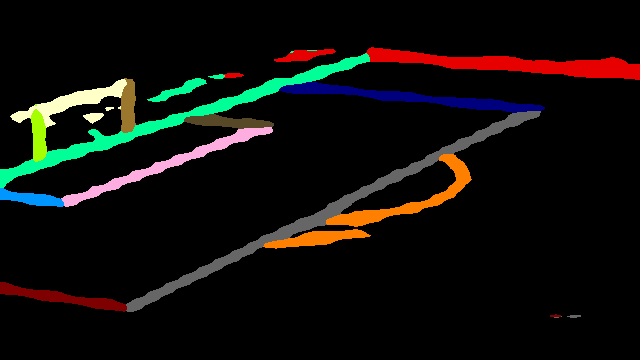

In [11]:
#Assigning each field line a separate color based on the palette provided in the code. 
mask = Image.fromarray(semlines.astype(np.uint8)).convert('P')
mask.putpalette(lines_palette)
mask_file = os.path.join(output_prediction_folder, frame_index + '.png')
mask.save(mask_file) # if you want to save file
mask

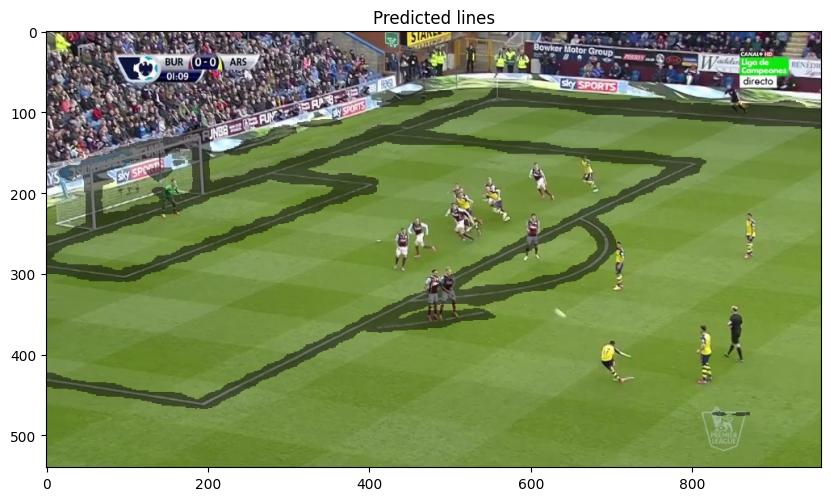

In [12]:
# Overlay the mask with the image
image_bkg = cv.cvtColor(image, cv.COLOR_BGR2RGB)
field_lines = cv.resize(semlines, (image.shape[1], image.shape[0]))
field_lines[field_lines>0] = 125
image_bkg[field_lines>0] = image_bkg[field_lines>0]//2
#Show the image with matplotlib
plt.figure(figsize= (10,15))
plt.title('Predicted lines')
plt.imshow(image_bkg)
plt.show()
# As we can see some mistakes include other lines(not field lines) included in one of the categories. ---> Area to improve

 - Next we have some code that uses the segmentation data to find line extremities. 
 - All the code is taken from the baseline in the repo. 
 - We do not need to use it to find extremities but it's a good starting point. 

In [13]:
skeletons = generate_class_synthesis(semlines, 6)

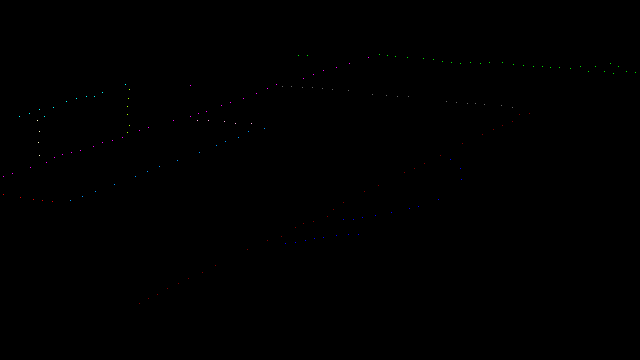

In [14]:
# Visualize skeletons.
skeletons_vis = np.zeros(semlines.shape).astype('uint8')
for k, class_name in enumerate(SoccerPitch.lines_classes):
    if class_name in skeletons.keys():
        for xy in skeletons[class_name]:
            skeletons_vis[xy[0], xy[1]] = k

skeletons_vis = Image.fromarray(skeletons_vis).convert('P')
skeletons_vis.putpalette(lines_palette)
skeletons_vis

In [15]:
resolution_width = 640
resolution_height = 360
extremities = get_line_extremities(skeletons, 40, resolution_width, resolution_height)

In [16]:
extremities

{'Big rect. left bottom': [{'x': 0.165625, 'y': 0.8444444444444444},
  {'x': 0.0046875, 'y': 0.8}],
 'Big rect. left main': [{'x': 0.2171875, 'y': 0.8416666666666667},
  {'x': 0.8265625, 'y': 0.3138888888888889}],
 'Big rect. left top': [{'x': 0.8, 'y': 0.2972222222222222},
  {'x': 0.440625, 'y': 0.2388888888888889}],
 'Circle left': [{'x': 0.4453125, 'y': 0.675},
  {'x': 0.703125, 'y': 0.44166666666666665}],
 'Goal left crossbar': [{'x': 0.0296875, 'y': 0.32222222222222224},
  {'x': 0.1953125, 'y': 0.23333333333333334}],
 'Goal left post left ': [{'x': 0.0578125, 'y': 0.3333333333333333},
  {'x': 0.0609375, 'y': 0.4305555555555556}],
 'Goal left post right': [{'x': 0.1984375, 'y': 0.36666666666666664},
  {'x': 0.2015625, 'y': 0.24722222222222223}],
 'Side line left': [{'x': 0.0046875, 'y': 0.4888888888888889},
  {'x': 0.575, 'y': 0.15833333333333333}],
 'Side line top': [{'x': 0.9921875, 'y': 0.2}, {'x': 0.5921875, 'y': 0.15}],
 'Small rect. left bottom': [{'x': 0.08125, 'y': 0.558333

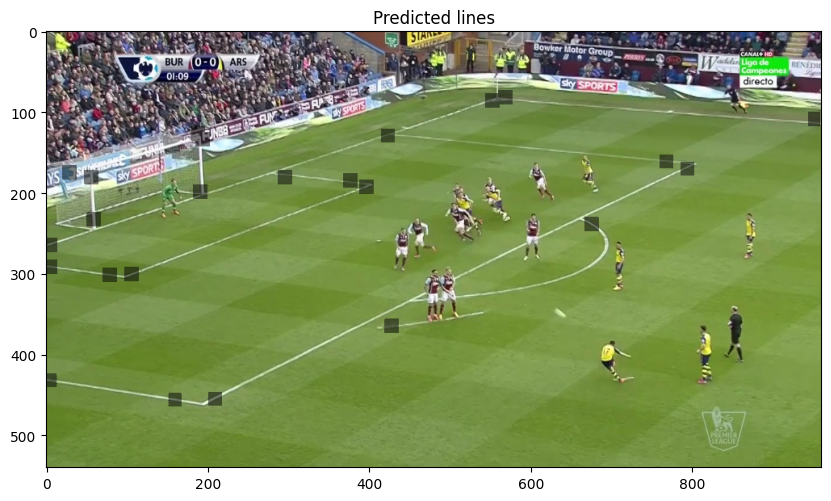

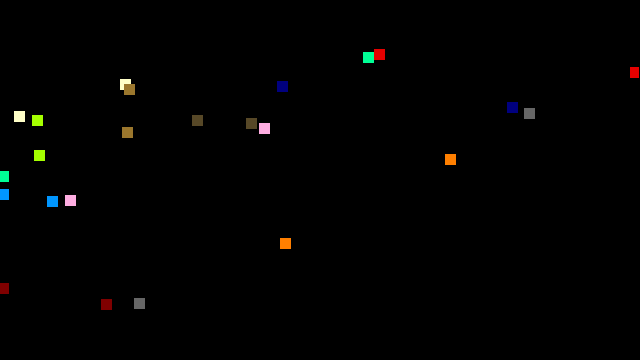

In [17]:
# Visualize extremities. Mark each point with a square of size 2*w + 1 and overlay over main image

w = 5
extremities_vis = np.zeros(semlines.shape).astype('uint8')
for k, class_name in enumerate(SoccerPitch.lines_classes):
    if class_name in extremities.keys():
        for xy in extremities[class_name]:
            y = int(xy['y']*resolution_height)
            x = int(xy['x']*resolution_width)
            extremities_vis[max(y-w,0):min(y+w+1,resolution_height-1), max(x-w,0):min(x+w+1,resolution_width-1) ] = k+1

           
image_bkg = cv.cvtColor(image, cv.COLOR_BGR2RGB)
extremities_overlay = cv.resize(extremities_vis, (image.shape[1], image.shape[0]))
extremities_overlay[extremities_overlay>0] = 125
image_bkg[extremities_overlay>0] = image_bkg[extremities_overlay>0]//2
#Show the image with matplotlib
plt.figure(figsize= (10,15))
plt.title('Predicted lines')
plt.imshow(image_bkg)
plt.show()
            
            
            
extremities_vis = Image.fromarray(extremities_vis).convert('P')
extremities_vis.putpalette(lines_palette)
extremities_vis

In [18]:
prediction_file = os.path.join(output_prediction_folder, f"extremities_{frame_index}.json")
with open(prediction_file, "w") as f:
    json.dump(extremities, f, indent=4)

### Evaluation
 - This is part 1 of the challenge. 
 - You get evaluated on how accurate are your extremities calculations

In [19]:
from src.evaluate_extremities import distance, \
                                     mirror_labels, \
                                     evaluate_detection_prediction, \
                                     scale_points # Scale dictionary of points from {0...1} to {res_width, res_height}  
#params
threshold = 10

In [20]:
output_prediction_folder, dataset_dir, frame_index, frame_index_int

('results\\valid', 'data\\calibration\\valid', '00001', 1)

In [21]:
annotation_files = [f for f in os.listdir(dataset_dir) if ".json" in f]

In [22]:
annotation_file = os.path.join(dataset_dir, annotation_files[frame_index_int])
prediction_file = os.path.join(output_prediction_folder,  f"extremities_{frame_index}.json")

with open(annotation_file, 'r') as f:
    line_annotations = json.load(f)

with open(prediction_file, 'r') as f:
    predictions = json.load(f)


In [23]:
print(f'Resolution width = {resolution_width}. Resolution_height = {resolution_height}')
print (prediction)
predictions = scale_points(predictions, resolution_width, resolution_height)
print (prediction)
line_annotations = scale_points(line_annotations, resolution_width, resolution_height)
img_prediction = predictions
img_groundtruth = line_annotations

Resolution width = 640. Resolution_height = 360
{}
{}


In [24]:
# Let's look at examples. Not the extremities can be in random order. The evaluate function takes care of that. 
'''
schema_part = 'Big rect. left bottom'
print(f"{schema_part}.\nPrediction = {img_prediction[schema_part]}.\nTruth      = {img_groundtruth[schema_part]}.")
'''

'\nschema_part = \'Big rect. left bottom\'\nprint(f"{schema_part}.\nPrediction = {img_prediction[schema_part]}.\nTruth      = {img_groundtruth[schema_part]}.")\n'

In [25]:
confusion1, per_class_conf1, reproj_errors1 = evaluate_detection_prediction(img_prediction,img_groundtruth, threshold)
confusion2, per_class_conf2, reproj_errors2 = evaluate_detection_prediction(img_prediction, mirror_labels(img_groundtruth),threshold)
accuracy1, accuracy2 = 0., 0.
if confusion1.sum() > 0:
    accuracy1 = confusion1[0, 0] / confusion1.sum()

if confusion2.sum() > 0:
    accuracy2 = confusion2[0, 0] / confusion2.sum()

if accuracy1 > accuracy2:
    accuracy = accuracy1
    confusion = confusion1
    per_class_conf = per_class_conf1
    reproj_errors = reproj_errors1
else:
    accuracy = accuracy2
    confusion = confusion2
    per_class_conf = per_class_conf2
    reproj_errors = reproj_errors2

precision = confusion[0, 0] / (confusion[0, :].sum())
recall = confusion[0, 0] / (confusion[0, 0] + confusion[1, 0])

In [26]:
print(f'accuracy = {accuracy}, precision = {precision}, recall = {recall}')
print(f'confusion = \n{confusion}')
for key, value in reproj_errors.items():
    print(key, ':', np.around(value,1))

accuracy = 0.625, precision = 0.625, recall = 1.0
confusion = 
[[15.  9.]
 [ 0.  0.]]
Big rect. left main : [13.4  6.8]
Side line left : [6.4 3.6]
Goal left post left  : [7.9 9.2]
Big rect. left bottom : [ 3.  23.7]
Small rect. left bottom : [ 1.4 13.7]
Small rect. left main : [6.4 3.2]
Goal left post right : [1.6 2.9]
Goal left crossbar : [17.7  4.1]
Small rect. left top : [18.6 11.5]
Circle left : [26.5 10.6]
Side line top : [7.  7.2]
Big rect. left top : [21.8  2.9]


In [27]:
reproj_errors

{'Big rect. left main': [13.351726134188349, 6.824885192295035],
 'Side line left': [6.383817620410189, 3.58899538881483],
 'Goal left post left ': [7.920312383657905, 9.177343462905638],
 'Big rect. left bottom': [3.0397517052849676, 23.71067108235987],
 'Small rect. left bottom': [1.392488729501688, 13.711619699912996],
 'Small rect. left main': [6.425185916285319, 3.206950119978865],
 'Goal left post right': [1.6493757079023201, 2.9134997478025584],
 'Goal left crossbar': [17.653715920110578, 4.088919400665856],
 'Small rect. left top': [18.605848017486874, 11.472454276352947],
 'Circle left': [26.482471990530062, 10.64163930789911],
 'Side line top': [6.994530802296164, 7.213871428481762],
 'Big rect. left top': [21.756794716695495, 2.9298923913484214]}

## Homography

 - Second part of the challenge 
 - Based on the image and extremities find camera parameters
 - Current baseline implementation only uses the extremities file to find camera calibration. We do not need to use only that. We could use other extracted information from the image. 

In [28]:
from src.camera import Camera
from src.soccerpitch import SoccerPitch
from src.baseline_cameras import normalization_transform #Computes the similarity transform such that the list of points is centered around (0,0) and that its distance to thecenter is sqrt(2).
from src.baseline_cameras import estimate_homography_from_line_correspondences
from src.baseline_cameras import draw_pitch_homography

In [29]:
output_prediction_folder, dataset_dir, frame, frame_index, frame_index_int,prediction_file, resolution_width, resolution_height

('results\\valid',
 'data\\calibration\\valid',
 '00001.jpg',
 '00001',
 1,
 'results\\valid\\extremities_00001.json',
 640,
 360)

In [30]:

with open(prediction_file, 'r') as f:
    predictions = json.load(f)
camera_predictions = dict()
image_path = os.path.join(dataset_dir, frame)
cv_image = cv.imread(image_path)
cv_image = cv.resize(cv_image, (resolution_width, resolution_height))

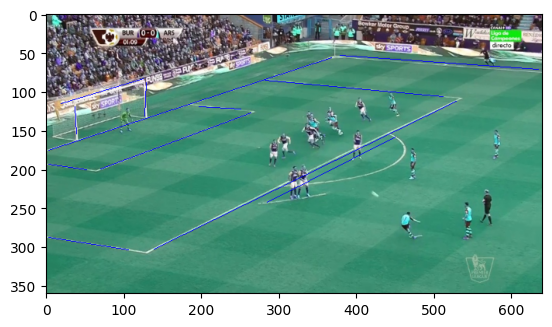

In [31]:
field = SoccerPitch()
line_matches = []
potential_3d_2d_matches = {}
src_pts = []
success = False
# For each prediction we attempt to find the corresponding line in the filed pitch schema. 
# Since we don't know which point in extremities is which end of the line, some points can have potential multiple matches
# You can uncomment some print statements to explore the loop

for k, v in predictions.items():
    if k == 'Circle central' or "unknown" in k:
        continue
    P3D1 = field.line_extremities_keys[k][0] # Dict key names of 
    P3D2 = field.line_extremities_keys[k][1]   
    
    p1 = np.array([v[0]['x'] * resolution_width, v[0]['y'] * resolution_height, 1.]) #line extremities
    p2 = np.array([v[1]['x'] * resolution_width, v[1]['y'] * resolution_height, 1.])
    #print(f'{k} ----  {P3D1}:{p1}.  {P3D2}:{p2}')        
    src_pts.extend([p1, p2])
    if P3D1 in potential_3d_2d_matches.keys():
        potential_3d_2d_matches[P3D1].extend([p1, p2])
    else:
        potential_3d_2d_matches[P3D1] = [p1, p2]
    if P3D2 in potential_3d_2d_matches.keys():
        potential_3d_2d_matches[P3D2].extend([p1, p2])
    else:
        potential_3d_2d_matches[P3D2] = [p1, p2]

    start = (int(p1[0]), int(p1[1]))
    end = (int(p2[0]), int(p2[1]))
    cv.line(cv_image, start, end, (0, 0, 255), 1)

    line = np.cross(p1, p2)
    if np.isnan(np.sum(line)) or np.isinf(np.sum(line)):
        continue
    line_pitch = field.get_2d_homogeneous_line(k) #line_pitch is the line on the field 2D coordinates. Excludes circle and goal posts
    if line_pitch is not None:
        line_matches.append((line_pitch, line))
        
#for k, v in potential_3d_2d_matches.items():
#    print(k,':', v)
    
plt.imshow(cv_image)

In [32]:
if len(line_matches) >= 4:
    print("line_matches = {line_matches}")
    target_pts = [field.point_dict[k][:2] for k in potential_3d_2d_matches.keys()]
    T1 = normalization_transform(target_pts)
    T2 = normalization_transform(src_pts)
    success, homography = estimate_homography_from_line_correspondences(line_matches, T1, T2)
    # H = np.reshape(homography, (9,)) fa diventare homography un vettore
    
    if success:
        print("success from first estimate = True")
        #cv_image = draw_pitch_homography(cv_image, homography)
        cam = Camera(resolution_width, resolution_height)      
        success = cam.from_homography(homography)
        print(homography)
        if success:
            print('Succesfully estimate homography. First approximation camera parameters...')
            """ for k,v in cam.to_json_parameters().items():
                print(k,':', v) """
            point_matches = []
            added_pts = set()
            for k, potential_matches in potential_3d_2d_matches.items():
                p3D = field.point_dict[k]
                projected = cam.project_point(p3D)

                if 0 < projected[0] < resolution_width and 0 < projected[1] < resolution_height:
                    print("0 < {projected[2]} < width & 0 < {projected[1]} < height")
                    dist = np.zeros(len(potential_matches))
                    for i, potential_match in enumerate(potential_matches):
                        dist[i] = np.sqrt((projected[0] - potential_match[0]) ** 2 + (
                                projected[1] - potential_match[1]) ** 2)
                    selected = np.argmin(dist)
                    if dist[selected] < 100:
                        print("dist[{selected}] < 100")
                        point_matches.append((p3D, potential_matches[selected][:2]))

            if len(point_matches) > 3:
                print('\n\nFound > 3 point matches. Refining homography. New camera parameters are... ')
                cam.refine_camera(point_matches)
                for k,v in cam.to_json_parameters().items():
                    print(k,':', v)                
                cam.draw_colorful_pitch(cv_image, SoccerPitch.palette)
                print(image_path)
                # cv.imshow("colorful pitch", cv_image)
                # cv.waitKey(0)

if success:
    camera_predictions = cam.to_json_parameters()
print(camera_predictions)
task2_prediction_file = os.path.join(output_prediction_folder, f"camera_{frame_index}.json")
if camera_predictions:
    with open(task2_prediction_file, "w") as f:
        json.dump(camera_predictions, f, indent=4)
else:
    print("Something went wrong")

line_matches = {line_matches}
success from first estimate = True
[[ 2.29858027e+01 -1.81054169e+01  1.31787013e+03]
 [ 1.40100670e+00  3.25030374e+00  2.87817029e+02]
 [-7.91188122e-03 -1.49997551e-02  1.00000000e+00]]
Succesfully estimate homography. First approximation camera parameters...
0 < {projected[2]} < width & 0 < {projected[1]} < height
dist[{selected}] < 100
0 < {projected[2]} < width & 0 < {projected[1]} < height
dist[{selected}] < 100
0 < {projected[2]} < width & 0 < {projected[1]} < height
dist[{selected}] < 100
0 < {projected[2]} < width & 0 < {projected[1]} < height
dist[{selected}] < 100
0 < {projected[2]} < width & 0 < {projected[1]} < height
dist[{selected}] < 100
0 < {projected[2]} < width & 0 < {projected[1]} < height
dist[{selected}] < 100
0 < {projected[2]} < width & 0 < {projected[1]} < height
dist[{selected}] < 100
0 < {projected[2]} < width & 0 < {projected[1]} < height
dist[{selected}] < 100
0 < {projected[2]} < width & 0 < {projected[1]} < height
dist[{sele

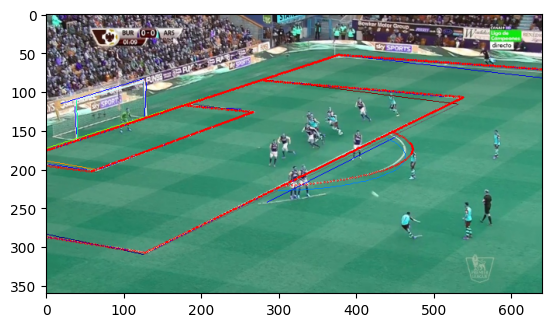

In [33]:
#Initial estimation of homography  based on line correspondences
plt.imshow(draw_pitch_homography(cv_image, homography))

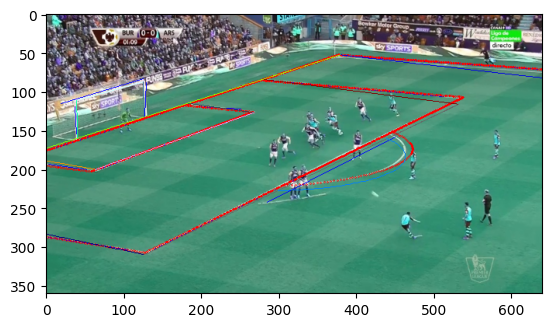

In [34]:
#Refined estimation of homography  based on line correspondences
plt.imshow(cam.draw_colorful_pitch(cv_image, SoccerPitch.palette))

# Finally let's take a look at how camera evaluation is done

In [35]:
from src.evaluate_camera import get_polylines
from src.evaluate_camera import evaluate_camera_prediction
from src.evaluate_camera import distance_to_polyline

In [36]:
accuracies = []
precisions = []
recalls = []
dict_errors = {}
per_class_confusion_dict = {}

In [37]:
annotation_files = [f for f in os.listdir(dataset_dir) if ".json" in f]
annotation_file = os.path.join(dataset_dir, annotation_files[frame_index_int])
prediction_file = os.path.join(output_prediction_folder, f"camera_{frame_index}.json")


with open(annotation_file, 'r') as f:
    line_annotations = json.load(f) #extremities annotations

with open(prediction_file, 'r') as f:
    predictions = json.load(f) # camera parameters

In [38]:
line_annotations = scale_points(line_annotations, resolution_width, resolution_height)

img_groundtruth = line_annotations # Extremities
print(predictions)
img_prediction = get_polylines(predictions, resolution_width, resolution_height, sampling_factor=0.9) # Field lines sampled at certain rate

{'pan_degrees': -27.843435885543418, 'tilt_degrees': 75.82137847497759, 'roll_degrees': -1.4237306009928956, 'position_meters': [-3.602790482147622, 66.85711762390244, -19.275937103718206], 'x_focal_length': 1652.6373501709832, 'y_focal_length': 1652.637350171065, 'principal_point': [320.0, 180.0], 'radial_distortion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'tangential_distortion': [0.0, 0.0], 'thin_prism_distortion': [0.0, 0.0, 0.0, 0.0]}


In [39]:
#img_prediction
img_groundtruth

{'Circle left': [{'x': 301.7099952697754, 'y': 222.4549913406372},
  {'x': 338.46500396728516, 'y': 219.7749924659729},
  {'x': 370.60001373291016, 'y': 216.3700032234192},
  {'x': 413.4400177001953, 'y': 208.09000253677368},
  {'x': 438.99497985839844, 'y': 200.30000925064087},
  {'x': 451.17000579833984, 'y': 192.5149941444397},
  {'x': 460.1749801635742, 'y': 184.96500492095947},
  {'x': 463.5799789428711, 'y': 175.22999167442322},
  {'x': 460.1749801635742, 'y': 166.71000838279724},
  {'x': 452.38502502441406, 'y': 160.14000177383423},
  {'x': 440.4549789428711, 'y': 154.29499626159668}],
 'Goal left post left ': [{'x': 38.01499843597412, 'y': 112.14499354362488},
  {'x': 39.639999866485596, 'y': 164.15500044822693}],
 'Goal left post right': [{'x': 127.40499496459961, 'y': 88.58000099658966},
  {'x': 129.035005569458, 'y': 134.0850019454956}],
 'Goal left crossbar': [{'x': 36.38999938964844, 'y': 112.95999884605408},
  {'x': 126.59500122070312, 'y': 87.76500105857849}],
 'Side lin

In [46]:
w = 3
thickness = 4
visg = np.zeros((resolution_height, resolution_width,3)).astype('uint8')
groundtruth = np.zeros((resolution_height, resolution_width,3)).astype('uint8')
visp = np.zeros((resolution_height, resolution_width)).astype('uint8')
vis = np.zeros((resolution_height, resolution_width)).astype('uint8')
 
for k, class_name in enumerate(SoccerPitch.lines_classes):
    if class_name in img_groundtruth.keys():        
        color=SoccerPitch.palette[class_name]
        ptsArray = []
        for xy in img_groundtruth[class_name]:   
            y = int(xy['y'])
            x = int(xy['x'])
            ptsArray.append([x,y])
            visg[max(y-w,0):min(y+w+1,resolution_height-1), max(x-w,0):min(x+w+1,resolution_width-1)] = k+1
            vis[max(y-w,0):min(y+w+1,resolution_height-1), max(x-w,0):min(x+w+1,resolution_width-1)] = k+1
        if class_name == 'Circle central':
            groundtruth = cv.polylines(groundtruth, ptsArray,color,isClosed=True,thickness=thickness)
        elif (class_name == 'Circle left' ) | (class_name == 'Circle right'):
            groundtruth = cv.polylines(groundtruth, ptsArray,color,isClosed=False,thickness=thickness)
        else:
            groundtruth = cv.line(groundtruth, ptsArray[0], ptsArray[1], color, thickness)
        # cv.polylines(visg,ptsArray,color=color,isClosed=False)
    if class_name in img_prediction.keys():
        for xy in img_prediction[class_name]:            
            y = int(xy['y'])
            x = int(xy['x'])
            visp[max(y-w,0):min(y+w+1,resolution_height-1), max(x-w,0):min(x+w+1,resolution_width-1) ] = k+1
            vis[max(y-w,0):min(y+w+1,resolution_height-1), max(x-w,0):min(x+w+1,resolution_width-1) ] = k+1
            
fig, axs = plt.subplots(1,3, figsize = (20,20))
extremities_vis = Image.fromarray(visg).convert('P')
extremities_vis.putpalette(lines_palette)
axs[0].imshow(groundtruth)
axs[0].set_title('ground truth')
extremities_vis = Image.fromarray(visp).convert('P')
extremities_vis.putpalette(lines_palette)
axs[1].imshow(extremities_vis)
axs[1].set_title('predictions')
extremities_vis = Image.fromarray(vis).convert('P')
extremities_vis.putpalette(lines_palette)
axs[2].imshow(extremities_vis)
axs[2].set_title('together')

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type


In [ ]:
# You can compare accuracies at different thresholds. Testing threshold 10. 
threshold = 10
confusion1, per_class_conf1, reproj_errors1 = evaluate_camera_prediction(img_prediction,img_groundtruth,threshold)
confusion2, per_class_conf2, reproj_errors2 = evaluate_camera_prediction(img_prediction,mirror_labels(img_groundtruth),threshold)
        
accuracy1, accuracy2 = 0., 0.
if confusion1.sum() > 0:
    accuracy1 = confusion1[0, 0] / confusion1.sum()

if confusion2.sum() > 0:
    accuracy2 = confusion2[0, 0] / confusion2.sum()

if accuracy1 > accuracy2:
    accuracy = accuracy1
    confusion = confusion1
    per_class_conf = per_class_conf1
    reproj_errors = reproj_errors1
else:
    accuracy = accuracy2
    confusion = confusion2
    per_class_conf = per_class_conf2
    reproj_errors = reproj_errors2

accuracy, reproj_errors

(0.8333333,
 {'Small rect. left main': [2.1538251390780516, 1.0540705626723426],
  'Goal left post left ': [0.9478478971387724, 2.7297943253438883],
  'Small rect. left top': [0.8867227258852634, 0.30343269189127],
  'Big rect. left main': [3.728234791790842, 9.384225355437355],
  'Side line left': [4.152932384448781, 4.279814430473067],
  'Side line top': [12.214983462623444, 5.5386142051647544],
  'Goal left post right': [2.030876733319746, 3.1647008240651755],
  'Big rect. left bottom': [1.1601693457036308, 15.159712736976864],
  'Big rect. left top': [9.379082621695101, 2.968622827822159],
  'Small rect. left bottom': [2.7064369793503804, 6.547108511005726],
  'Circle left': [6.593383423574058,
   7.117530885438804,
   6.818708435162071,
   6.260475534096656,
   4.56286888755009,
   4.072492690736881,
   0.8438055759666087,
   6.573783903964754,
   8.970688983407731,
   9.132387073210014,
   8.374879693787081],
  'Goal left crossbar': [1.5418109448363575, 1.8319436820972037]})

In [ ]:

print("Total Execution Time is "+str(time.time()-actual_time)+" seconds")
""" stats_dir = os.path.join('results', 'stats')
camera_dir = os.path.join(stats_dir, 'camera')
detections_dir = os.path.join(stats_dir, 'detections')

print("camera stats")
_accuracies = os.path.join(camera_dir, 'accuracies.json')
with open(_accuracies, 'r') as f:
    accuracies = json.load(f)
accuracies


_reproj_errors = os.path.join(camera_dir, 'reproj_errors.json')
with open(_reproj_errors, 'r') as f:
    reproj_errors = json.load(f)
reproj_errors

print("detection stats")
_precisions = os.path.join(detections_dir, 'precisions.json')
with open(_precisions, 'r') as f:
    precisions = json.load(f)
precisions

_recalls = os.path.join(detections_dir, 'recalls.json')
with open(_recalls, 'r') as f:
    recalls = json.load(f)
recalls

_reproj_errors = os.path.join(detections_dir, 'reproj_errors.json')
with open(_reproj_errors, 'r') as f:
    reproj_errors = json.load(f)
reproj_errors """ 

Total Execution Time is 19.59118390083313 seconds


' stats_dir = os.path.join(\'results\', \'stats\')\ncamera_dir = os.path.join(stats_dir, \'camera\')\ndetections_dir = os.path.join(stats_dir, \'detections\')\n\nprint("camera stats")\n_accuracies = os.path.join(camera_dir, \'accuracies.json\')\nwith open(_accuracies, \'r\') as f:\n    accuracies = json.load(f)\naccuracies\n\n\n_reproj_errors = os.path.join(camera_dir, \'reproj_errors.json\')\nwith open(_reproj_errors, \'r\') as f:\n    reproj_errors = json.load(f)\nreproj_errors\n\nprint("detection stats")\n_precisions = os.path.join(detections_dir, \'precisions.json\')\nwith open(_precisions, \'r\') as f:\n    precisions = json.load(f)\nprecisions\n\n_recalls = os.path.join(detections_dir, \'recalls.json\')\nwith open(_recalls, \'r\') as f:\n    recalls = json.load(f)\nrecalls\n\n_reproj_errors = os.path.join(detections_dir, \'reproj_errors.json\')\nwith open(_reproj_errors, \'r\') as f:\n    reproj_errors = json.load(f)\nreproj_errors '